In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import csv
import ast

In [15]:
multi_task_data = pd.read_csv('../raw_data/multi_task_data_with_dv_by_rounds.csv')

In [16]:
muti_task_chat = multi_task_data[["_id", "gameId", "data.A"]].drop_duplicates()

Grouping variables:
- StageID: Task/complexity pair and team size (smallest level)
- RoundID: Task (_id in the table below): a given round should encapsulate all the things people did (mid-level)
- GameID: Everything they did in the entire game

Within that, order chronologically at the level of the ID that you're looking at.

In [17]:
multi_task_data

# unit: grouping of 6 repetitions of a common set of randomly ordered tasks
# since we have 10 tasks and people can't do 10 tasks in a row, we split them into "units"
# in a unit, there are 2 slides: (1) first 5 tasks; (2) second 5 tasks. Each task is randomly ordered, but repeatably (we repeat each unit some number of times)

,_id,gameId,createdAt,index,stageIds,data.type,data.name,data.anonName,data.current_round,data.A,unit,playerCount,task,complexity,score,speed,efficiency,raw_duration_min,default_duration_min
0,fi42h33RCL5NzBNxw,9qn6LAzd4Fs9nf2KD,2023-04-10T15:12:50Z,4,wTtnYPymbumNdGkqS,MoralReasoning,Moral Reasoning,Game 5,4,"{""text"":""I'm getting an error on this page are...",1,3,Moral Reasoning,Low,0.0,38.276872,0.000000,3.086167,5
1,fi42h33RCL5NzBNxw,9qn6LAzd4Fs9nf2KD,2023-04-10T15:12:50Z,4,jKvQoGxqtb4JZ2q9o,MoralReasoning,Moral Reasoning,Game 5,4,"{""text"":""I'm getting an error on this page are...",1,3,Moral Reasoning,Medium,0.0,57.929140,0.000000,2.103550,5
2,fi42h33RCL5NzBNxw,9qn6LAzd4Fs9nf2KD,2023-04-10T15:12:50Z,4,8eDYCY8W9uCGCbg8K,MoralReasoning,Moral Reasoning,Game 5,4,"{""text"":""I'm getting an error on this page are...",1,3,Moral Reasoning,High,0.0,66.676111,0.000000,1.666200,5
3,QBfbTfQCoJFrBKq8P,9qn6LAzd4Fs9nf2KD,2023-04-10T15:12:50Z,0,7HwXhDZAbBbjimTma,RoomAssignment,Room Assignment,Game 1,0,"{""text"":""this one is challenging"",""player"":{""_...",1,3,Room Assignment,Low,86.0,40.481865,3481.440395,2.975917,5
4,QBfbTfQCoJFrBKq8P,9qn6LAzd4Fs9nf2KD,2023-04-10T15:12:50Z,0,DPMTfdfK7TNBMQzr6,RoomAssignment,Room Assignment,Game 1,0,"{""text"":""this one is challenging"",""player"":{""_...",1,3,Room Assignment,Medium,91.0,0.168333,15.318282,4.991600,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,327x9knxnsj4aaPjD,mjehBbrezMnafKtPB,2023-09-06T19:43:35Z,3,y5BnQMBzyuqYPi4Cx,WolfGoatCabbage,Wolf Goat Cabbage,Game 4,3,"{""text"":""goat on one side and just approve"",""p...",4,3,Wolf Goat Cabbage,High,60.0,17.278609,1036.716544,4.136083,5
1391,327x9knxnsj4aaPjD,mjehBbrezMnafKtPB,2023-09-06T19:43:35Z,3,yZEpzgxumLFMEaY4T,WolfGoatCabbage,Wolf Goat Cabbage,Game 4,3,"{""text"":""goat on one side and just approve"",""p...",4,3,Wolf Goat Cabbage,Low,0.0,15.752281,0.000000,4.212400,5
1392,ypzhuTMANP3M3iht9,mjehBbrezMnafKtPB,2023-09-06T19:43:35Z,4,J7aBjR8d5BkdReojo,AllocatingResources,Allocating Resources,Game 5,4,"{""text"":""can't do 100,000. it needs 400000 to ...",4,3,Allocating Resources,Medium,100.0,0.000556,0.055555,3.019517,3
1393,ypzhuTMANP3M3iht9,mjehBbrezMnafKtPB,2023-09-06T19:43:35Z,4,4xfgW4gtPoBK6yrKS,AllocatingResources,Allocating Resources,Game 5,4,"{""text"":""can't do 100,000. it needs 400000 to ...",4,3,Allocating Resources,High,50.0,77.660124,3883.006206,0.670200,3


In [18]:
multi_task_stages = pd.read_csv('../raw_data/multi_task_stages.csv')

/var/folders/gy/yd7v599s1qd49r7p_bgk88lr0000gn/T/ipykernel_75186/2616241572.py:1: DtypeWarning: Columns (2,3,4,9,10,11,13,14,15,21,26,28,33,34,39,40,41,42,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,77,83,84,85,87,88,89,91,95,97,99,100,101,102,103,104,105,106,109,110,111,115,117,120,122,123,131,132,133,134,137,138,139,140,141,142,143,144,145,146,148,160) have mixed types. Specify dtype option on import or set low_memory=False.
  multi_task_stages = pd.read_csv('../raw_data/multi_task_stages.csv')


In [19]:
'''
Build a dictionary that allows us to look up the stages from the gameId
key: gameId
  value:
    { key: roundId
        value:{
            key: stageId 1
            value: timestamp for stage 1 start

            key: stageId 2
            value: timestamp for stage 2 start, 

            key: stageId 3
            value: timestamp for stage 3 start, 
        }
    }
'''
game_id_lookup = {}

for index, row in multi_task_data.iterrows():
    cur_gameid = row['gameId']
    if cur_gameid not in game_id_lookup.keys():
        # add it
        game_id_lookup.update({cur_gameid: {}})

    # get current task, stageId, and complexity
    roundId = row["_id"]
    stageId = row["stageIds"]

    # ensure current task is updated in dict:
    if roundId not in game_id_lookup[cur_gameid].keys():
        # add it
        game_id_lookup[cur_gameid].update({roundId: {}})

    # update the dictionary
    game_id_lookup[cur_gameid][roundId].update({stageId: multi_task_stages[multi_task_stages["_id"]==stageId]["startTimeAt"].unique()[0]})

In [20]:
game_id_lookup["6rmMh8CE3iCeawScL"]["2LrZhHPftiKcJjqPR"]

# LvdAaeJYKtMwtZWnu is appearing out of nowhere...

{'yjDr4pRWkpa8juqBu': '2023-08-10T21:49:44Z',
 'uMsW7gHcgKAHYgt67': '2023-08-10T21:54:45Z',
 'DzaZDKrnvvw9uPiCk': '2023-08-10T21:58:50Z'}

In [21]:
with open('../raw_data/multi_task_conversations.csv', 'w', newline='') as csvfile:
    # start writing the header of the CSV
    fieldnames = ["stageId", "roundId", "gameId", "message", "speaker_nickname", "timestamp"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for index, row in muti_task_chat.iterrows():
        chat = "[" + row['data.A'] + "]" # convert messages to a list of dict objects
        chat_list = eval(chat)

        game_id = row["gameId"]
        round_id = row["_id"]

        # Get timing for all the stages
        # Sort the stage ID's by value (which is the timestamp)
        stage_dict = dict(sorted(game_id_lookup[game_id][round_id].items(), key=lambda item: item[1]))
        stageIds = list(stage_dict.keys())
        stage_timings = list(stage_dict.values())
        
        for chat in chat_list:
          text = chat['text']
          speaker = chat['player']['_id']
          timestamp = chat['timeStamp']
          stage_id = ""

          # Determine which stage a chat was spoken in
          if(len(stageIds) == 3):
            if(timestamp < stage_timings[1]):
              stage_id = stageIds[0]
            if(timestamp >= stage_timings[1] and timestamp < stage_timings[2]):
                stage_id = stageIds[1]
            if(timestamp >= stage_timings[2]):
                stage_id = stageIds[2]
          elif(timestamp == 2):
            if(timestamp < stage_timings[1]):
              stage_id = stageIds[0]
            if(timestamp >= stage_timings[1]):
              stage_id = stageIds[1]
          else:
              stage_id = stageIds[0]

          chat_obj = {'stageId':stage_id, 'roundId': round_id, 'gameId':game_id, 'message': text, 'speaker_nickname': speaker, 'timestamp': timestamp}

          # Write the row
          writer.writerow(chat_obj)

In [22]:
conversations_raw = pd.read_csv('../raw_data/multi_task_conversations.csv').sort_values(['gameId', 'roundId', 'stageId','timestamp'])

This generates the chat conversations alongside the dependent variables

In [23]:
multi_task_dv = multi_task_data[["_id", "stageIds", "task", "complexity", "playerCount", "score", "speed", "efficiency", "raw_duration_min", "default_duration_min"]]
multi_task_dv = multi_task_dv.rename(columns = {"stageIds": "stageId", "_id": "roundId"})

In [24]:
multi_task_dv = multi_task_dv.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)

In [25]:
conversations_with_dv = conversations_raw.merge(multi_task_dv, on=["roundId", "stageId"], how="left")

conversations_with_dv.to_csv('../raw_data/multi_task_conversations_with_dv.csv', index=False)

Add in user/composition information

In [26]:
user_info = pd.read_csv('../raw_data/results_by_user_detailed.csv').rename(columns = {"stageIds": "stageId"})

Summary Statistics

Numeric: 
- 'birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR', 'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME'

Non-Numeric (recoded manually):
- 'country', 'education_level', 'gender', 'marital_status', 'political_party', 'race'

In [27]:
threshold = 0.8  # 80% threshold
user_info = user_info.dropna(axis=1, thresh=int(threshold * len(user_info)))

#### TODO --- figure out better way to handle NA's here!

Recode everything into numeric:
- Country: 1 if US, 0 otherwise
- Education: ordinal variable (-1 if NA)
- Gender: 0 if Male, 1 if Female, 2 if other, -1 if NA
- Marital Status: ordinal variable (-1 if NA)
- Political party: ordinal variable (-1 if NA)
- Race: 1 if White, 0 otherwise

In [28]:
user_info.loc[:, 'country'] = (user_info['country'] == 'United States').astype(int)

In [29]:
education_order = [
    'Less than a high school diploma',
    'High school diploma',
    'Some college or vocational training',
    '2-year college degree',
    '4-year college degree',
    'Post-college degree'
]
user_info['education_level'] = pd.Categorical(user_info['education_level'], categories=education_order, ordered=True)
user_info['education_level_numeric'] = user_info['education_level'].cat.codes

In [30]:
gender_order = [
    'Male',
    'Female',
    'Other'
]
user_info['gender'] = pd.Categorical(user_info['gender'], categories=gender_order, ordered=True)
user_info['gender'] = user_info['gender'].cat.codes

In [31]:
user_info['gender'].value_counts()

gender
 0    3326
 1    2555
 2      57
-1      30
Name: count, dtype: int64

In [32]:
maritalstatus_order = [
    'Single Never Married',
    'Married or Domestic Partnership',
    'Divorced',
    'Widowed',
    'Separated'
]
user_info['marital_status'] = pd.Categorical(user_info['marital_status'], categories=maritalstatus_order, ordered=True)
user_info['marital_status'] = user_info['marital_status'].cat.codes

In [33]:
politicalparty_order = [
    'Democrat',
    'Independent',
    'Republican',
    'Other Party',
    'Neutral'
]
user_info['political_party'] = pd.Categorical(user_info['political_party'], categories=politicalparty_order, ordered=True)
user_info['political_party'] = user_info['political_party'].cat.codes

In [34]:
user_info.loc[:, 'race'] = (user_info['race'] == 'White').astype(int)

In [35]:
user_features_numeric = user_info[['birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR', 'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME', 'country', 'education_level', 'gender', 'marital_status', 'political_party', 'race']]

In [36]:
numeric_columns = user_features_numeric.select_dtypes(include='number').columns.difference(['stageId'])

# Group by 'ID' and calculate mean and std for all numeric columns
grouped_df = user_info.groupby('stageId')[numeric_columns].agg([np.nanmean, np.nanstd])

# Flatten the multi-level column index
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]


In [37]:
grouped_df

,CRT_nanmean,CRT_nanstd,IRCS_GS_nanmean,IRCS_GS_nanstd,IRCS_GV_nanmean,IRCS_GV_nanstd,IRCS_IB_nanmean,IRCS_IB_nanstd,IRCS_IR_nanmean,IRCS_IR_nanstd,...,income_min_nanmean,income_min_nanstd,marital_status_nanmean,marital_status_nanstd,political_fiscal_nanmean,political_fiscal_nanstd,political_party_nanmean,political_party_nanstd,political_social_nanmean,political_social_nanstd
stageId,,,,,,,,,,,,,,,,,,,,,
22bJZWfgB3gfKXY6A,0.714286,0.257319,4.208333,0.579152,4.533333,1.032796,4.875000,0.945384,5.833333,0.722649,...,58333.333333,45789.372857,1.166667,1.169045,0.600000,0.252982,0.833333,0.752773,0.533333,0.273252
22wFrSqgf8ESM8pNY,0.849206,0.143517,4.416667,0.629153,4.066667,0.986577,5.750000,0.750000,5.777778,1.347151,...,41666.666667,32532.035493,1.333333,1.527525,0.666667,0.305505,1.666667,1.154701,0.533333,0.230940
26RnwcdY842ZGSQtT,0.468254,0.265488,4.416667,1.607275,4.066667,1.700980,5.500000,1.322876,6.222222,0.769800,...,55000.000000,18027.756377,0.666667,0.577350,0.600000,0.400000,0.666667,0.577350,0.400000,0.200000
2EwFHSGkq5yCtEkv4,0.702381,0.360067,4.000000,0.500000,4.300000,1.288410,5.000000,0.570088,5.555556,0.779363,...,58333.333333,45789.372857,0.833333,0.752773,0.600000,0.282843,0.666667,1.032796,0.433333,0.233809
2JYQTGJLz2fh2AHyr,0.674603,0.288461,4.500000,0.293610,4.300000,0.661764,5.125000,0.700215,5.722222,0.455560,...,53333.333333,35557.950111,0.666667,0.758098,0.533333,0.224888,1.000000,1.017095,0.566667,0.319842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhMsuZhQvLkeWWFwM,0.527778,0.427092,4.083333,0.970395,4.433333,1.007307,5.166667,1.044829,5.777778,0.807373,...,40833.333333,22453.655976,0.666667,1.211060,0.600000,0.219089,1.166667,1.169045,0.566667,0.150555
zjF7T8EffBLneRkvC,0.553571,0.375645,4.187500,0.375000,4.500000,1.238278,5.000000,1.670828,5.333333,0.720082,...,41250.000000,27801.378863,1.000000,0.816497,0.450000,0.191485,0.500000,0.577350,0.350000,0.191485
zq4k4kqAGjYMJ4nP2,0.642857,0.428571,4.187500,0.239357,4.150000,0.838650,5.375000,0.595119,5.333333,0.608581,...,62500.000000,59651.767227,0.000000,0.000000,0.450000,0.251661,0.500000,1.000000,0.550000,0.191485


In [38]:
composition_by_stageId = grouped_df

In [39]:
# This dataframe aggregates all the composition-level features
conversations_with_dv_and_composition = conversations_with_dv.merge(composition_by_stageId, on = "stageId", how = "left")

# fill NA messages and speakers if necessary
conversations_with_dv_and_composition["message"] = conversations_with_dv_and_composition["message"].fillna("NULL_MESSAGE")
conversations_with_dv_and_composition["speaker_nickname"] = conversations_with_dv_and_composition["speaker_nickname"].fillna("NULL_SPEAKER")

conversations_with_dv_and_composition.to_csv('../raw_data/multi_task_conversations_with_dv_and_composition.csv', index=False)

In [40]:
# TODO -- decide how to handle when the stdev is NA.

conversations_with_dv_and_composition

,stageId,roundId,gameId,message,speaker_nickname,timestamp,task,complexity,playerCount,score,...,income_min_nanmean,income_min_nanstd,marital_status_nanmean,marital_status_nanstd,political_fiscal_nanmean,political_fiscal_nanstd,political_party_nanmean,political_party_nanstd,political_social_nanmean,political_social_nanstd
0,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,How are we deciding which ones will go into th...,YYDdpWfhjAnzmC4nY,2023-08-18T19:13:21.215Z,Divergent Association,Medium,3,85.040573,...,66666.666667,14433.756730,0.666667,0.577350,0.333333,0.115470,0.00,0.000000,0.200000,0.000000
1,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,we get to 10 first,o8MuyZu2aoM982cjt,2023-08-18T19:14:14.889Z,Divergent Association,Medium,3,85.040573,...,66666.666667,14433.756730,0.666667,0.577350,0.333333,0.115470,0.00,0.000000,0.200000,0.000000
2,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,then eliminate,o8MuyZu2aoM982cjt,2023-08-18T19:14:21.628Z,Divergent Association,Medium,3,85.040573,...,66666.666667,14433.756730,0.666667,0.577350,0.333333,0.115470,0.00,0.000000,0.200000,0.000000
3,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,good?,o8MuyZu2aoM982cjt,2023-08-18T19:14:30.611Z,Divergent Association,Medium,3,85.040573,...,66666.666667,14433.756730,0.666667,0.577350,0.333333,0.115470,0.00,0.000000,0.200000,0.000000
4,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,I'm good with that.,YYDdpWfhjAnzmC4nY,2023-08-18T19:14:39.920Z,Divergent Association,Medium,3,85.040573,...,66666.666667,14433.756730,0.666667,0.577350,0.333333,0.115470,0.00,0.000000,0.200000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9070,mCnaFjCJKeRGGQrkA,EBg2CGK9R7fHrdtEw,yvxthDwLgfm8Z8PDt,"wait, new prompt hah",3Tu6gRju5LTHrYDvP,2023-06-13T21:06:36.908Z,Moral Reasoning,High,6,90.000000,...,25000.000000,17320.508076,1.500000,1.000000,0.450000,0.251661,0.75,0.957427,0.450000,0.251661
9071,mCnaFjCJKeRGGQrkA,EBg2CGK9R7fHrdtEw,yvxthDwLgfm8Z8PDt,ESH is good,3Tu6gRju5LTHrYDvP,2023-06-13T21:09:01.456Z,Moral Reasoning,High,6,90.000000,...,25000.000000,17320.508076,1.500000,1.000000,0.450000,0.251661,0.75,0.957427,0.450000,0.251661
9072,mCnaFjCJKeRGGQrkA,EBg2CGK9R7fHrdtEw,yvxthDwLgfm8Z8PDt,I agree with your response. Everyone seems ba...,3pq6sn9HcHZXhKGur,2023-06-13T21:09:46.301Z,Moral Reasoning,High,6,90.000000,...,25000.000000,17320.508076,1.500000,1.000000,0.450000,0.251661,0.75,0.957427,0.450000,0.251661
9073,7ZkN6FJBHMPioZ2ci,3WQXb5EHZPHGYbW78,z2KR2Ki2DiXWRbTHy,Is it possible?,vuvNvYXXY348doFKs,2023-09-05T18:43:14.967Z,Wolf Goat Cabbage,Low,3,0.000000,...,13333.333333,15275.252317,1.666667,1.527525,0.400000,0.200000,0.00,0.000000,0.266667,0.115470


Units of Analysis:

- Entire Game: `gameId`
- Task: `roundId`
- Task Instance (complexity): `stageId`
- Aggregation of conversation *up until this point** in the task, or in the game

In [41]:
# Create example dataframe

df = pd.DataFrame(
    {
        "stageId": ["g1r1stage1", "g1r1stage1", "g1r1stage2", "g1r1stage2", "g1r2stage1", "g1r2stage1", "g1r2stage2", "g1r2stage2"],
        "roundId": ["game1round1", "game1round1", "game1round1", "game1round1", "game1round2", "game1round2", "game1round2", "game1round2"],
        "gameId": ["game1","game1", "game1", "game1", "game1","game1", "game1", "game1"],
        "message": ["hi!", "hey!", "hello hello 1", "hello hello 2", "start of round 2", "round 2 is nice", "almost there", "that's it!"],
        "timestamp": [1,2,3,4,5,6,7,8]
    }
)

df

,stageId,roundId,gameId,message,timestamp
0,g1r1stage1,game1round1,game1,hi!,1
1,g1r1stage1,game1round1,game1,hey!,2
2,g1r1stage2,game1round1,game1,hello hello 1,3
3,g1r1stage2,game1round1,game1,hello hello 2,4
4,g1r2stage1,game1round2,game1,start of round 2,5
5,g1r2stage1,game1round2,game1,round 2 is nice,6
6,g1r2stage2,game1round2,game1,almost there,7
7,g1r2stage2,game1round2,game1,that's it!,8


In [42]:
simple_input = pd.DataFrame(
    {
        "stageId": ["g1r1stage1", "g1r1stage1", "g1r1stage2", "g1r1stage2"],
        "roundId": ["game1round1", "game1round1", "game1round1", "game1round1"],
        "gameId": ["game1","game1", "game1", "game1"],
        "message": ["hi!", "hey!", "hello hello 1", "hello hello 2"],
        "timestamp": [1,2,3,4]
    }
)

simple_output = pd.DataFrame(
    {
        "stageId": ["g1r1stage1", "g1r1stage1", "g1r1stage1", "g1r1stage1", "g1r1stage2", "g1r1stage2"],
        "roundId": ["game1round1", "game1round1", "game1round1", "game1round1", "game1round1", "game1round1"],
        "gameId": ["game1", "game1", "game1", "game1", "game1", "game1"],
        "message": ["hi!", "hey!", "hi!", "hey!", "hello hello 1", "hello hello 2"],
        "timestamp": [1,2,1,2,3,4],
        "cumulative_stageId": [0,0,1,1,1,1]
    }
)

In [43]:
def create_cumulative_rows(input_df, conversation_id, within_task = False):
	"""
	function: create_cumulative_rows

	This function takes a chat-level dataframe and duplicates rows such that we can analyze
	convesations in the context of what came before.

	For example, rather than analyzing only the chats from a single stage, this function makes it possible
	to also incorporate chats from previous stages / tasks in the same conversation.
	
	@param conversation_id: The ID (stage or round) that the user wants to group on.
	@param within_task (defaults to False). This parameter determines whether we want to restrict
	the analysis only to chats that were of the same task (e.g., same `roundId`). By default, we look at 
	every chat that came before, regardless of the task.
	"""

	# If the conversation_id is the gameId, return as is -- no changes requred
	if(conversation_id == "gameId"): return input_df

	result_df = pd.DataFrame(columns=input_df.columns)

	# prev stageId
	prev_stageId = None

	# Iterate through rows
	for index, current_row in input_df.iterrows():
			
		# current stageId
		if current_row["stageId"] != prev_stageId: # we have transitioned to a new stageId

			prev_stageId = current_row["stageId"]

			if(conversation_id == 'stageId'):
				# Duplicate rows from all previous stageId's with the same 'gameId'
				if(within_task): # ensure roundId's are the same
					previous_rows = input_df.loc[(input_df['stageId'] != current_row['stageId']) & (input_df['timestamp'] < current_row['timestamp']) & (input_df['gameId'] == current_row['gameId']) & (input_df['roundId'] == current_row['roundId'])].copy()
				else:
					previous_rows = input_df.loc[(input_df['stageId'] != current_row['stageId']) & (input_df['timestamp'] < current_row['timestamp']) & (input_df['gameId'] == current_row['gameId'])].copy()
				if(not previous_rows.empty):
					previous_rows['cumulative_Id'] = current_row["stageId"]
					result_df = pd.concat([result_df, previous_rows], ignore_index=True)
			if(conversation_id == 'roundId'):
				# Duplicate rows from all previous roundId's with the same gameId
				previous_rows = input_df.loc[(input_df['roundId'] != current_row['roundId']) & (input_df['timestamp'] < current_row['timestamp']) & (input_df['gameId'] == current_row['gameId'])].copy()
				if(not previous_rows.empty):
					previous_rows['cumulative_Id'] = current_row["roundId"]
					result_df = pd.concat([result_df, previous_rows], ignore_index=True)

			cur_Id_rows = input_df.loc[(input_df[conversation_id] == current_row[conversation_id])].copy()
			cur_Id_rows['cumulative_Id'] = current_row[conversation_id]
			# Concatenate the current row to the result DataFrame
			result_df = pd.concat([result_df, cur_Id_rows], ignore_index=True).drop_duplicates()

	return result_df

In [44]:
create_cumulative_rows(df, conversation_id= "roundId", within_task = False)

,stageId,roundId,gameId,message,timestamp,cumulative_Id
0,g1r1stage1,game1round1,game1,hi!,1,game1round1
1,g1r1stage1,game1round1,game1,hey!,2,game1round1
2,g1r1stage2,game1round1,game1,hello hello 1,3,game1round1
3,g1r1stage2,game1round1,game1,hello hello 2,4,game1round1
4,g1r1stage1,game1round1,game1,hi!,1,game1round2
5,g1r1stage1,game1round1,game1,hey!,2,game1round2
6,g1r1stage2,game1round1,game1,hello hello 1,3,game1round2
7,g1r1stage2,game1round1,game1,hello hello 2,4,game1round2
8,g1r2stage1,game1round2,game1,start of round 2,5,game1round2
9,g1r2stage1,game1round2,game1,round 2 is nice,6,game1round2


In [45]:
multi_task_tiny = pd.read_csv("../raw_data/multi_task_TINY.csv")

In [46]:
create_cumulative_rows(multi_task_tiny, conversation_id= "stageId", within_task = False)

,stageId,roundId,gameId,message,speaker_nickname,timestamp,task,complexity,playerCount,score,...,income_min_nanstd,marital_status_nanmean,marital_status_nanstd,political_fiscal_nanmean,political_fiscal_nanstd,political_party_nanmean,political_party_nanstd,political_social_nanmean,political_social_nanstd,cumulative_Id
0,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,How are we deciding which ones will go into th...,YYDdpWfhjAnzmC4nY,2023-08-18T19:13:21.215Z,Divergent Association,Medium,3,85.040573,...,14433.75673,0.666667,0.577350,0.333333,0.11547,0.000000,0.00000,0.200000,0.00000,EWWBeNEDqRu3XFgkK
1,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,we get to 10 first,o8MuyZu2aoM982cjt,2023-08-18T19:14:14.889Z,Divergent Association,Medium,3,85.040573,...,14433.75673,0.666667,0.577350,0.333333,0.11547,0.000000,0.00000,0.200000,0.00000,EWWBeNEDqRu3XFgkK
2,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,then eliminate,o8MuyZu2aoM982cjt,2023-08-18T19:14:21.628Z,Divergent Association,Medium,3,85.040573,...,14433.75673,0.666667,0.577350,0.333333,0.11547,0.000000,0.00000,0.200000,0.00000,EWWBeNEDqRu3XFgkK
3,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,good?,o8MuyZu2aoM982cjt,2023-08-18T19:14:30.611Z,Divergent Association,Medium,3,85.040573,...,14433.75673,0.666667,0.577350,0.333333,0.11547,0.000000,0.00000,0.200000,0.00000,EWWBeNEDqRu3XFgkK
4,EWWBeNEDqRu3XFgkK,Gqr28S5MXb3274kHB,3MRRSzADf8pKKfvKQ,I'm good with that.,YYDdpWfhjAnzmC4nY,2023-08-18T19:14:39.920Z,Divergent Association,Medium,3,85.040573,...,14433.75673,0.666667,0.577350,0.333333,0.11547,0.000000,0.00000,0.200000,0.00000,EWWBeNEDqRu3XFgkK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,pc8XdJAd6BdhpxnXi,yj43a6THKN3sMe6s7,4w3ZbKnFmhrtdbFtm,A LOT OF MONEY,N96j34eqDrcr3ynzW,2023-05-05T21:22:32.540Z,Moral Reasoning,Low,3,80.000000,...,26457.51311,0.666667,1.154701,0.666667,0.23094,1.333333,0.57735,0.666667,0.23094,um4a8KcjpXadT73Ky
1488,pc8XdJAd6BdhpxnXi,yj43a6THKN3sMe6s7,4w3ZbKnFmhrtdbFtm,HOW ABOUT STARTING WITH 50k,N96j34eqDrcr3ynzW,2023-05-05T21:22:45.904Z,Moral Reasoning,Low,3,80.000000,...,26457.51311,0.666667,1.154701,0.666667,0.23094,1.333333,0.57735,0.666667,0.23094,um4a8KcjpXadT73Ky
1489,um4a8KcjpXadT73Ky,yj43a6THKN3sMe6s7,4w3ZbKnFmhrtdbFtm,"do we really need 100,000 for computers",yXoZyCbHHDGyDHvQa,2023-05-05T21:25:19.314Z,Allocating Resources,Medium,3,70.000000,...,26457.51311,0.666667,1.154701,0.666667,0.23094,1.333333,0.57735,0.666667,0.23094,um4a8KcjpXadT73Ky
1490,um4a8KcjpXadT73Ky,yj43a6THKN3sMe6s7,4w3ZbKnFmhrtdbFtm,just sayin,yXoZyCbHHDGyDHvQa,2023-05-05T21:25:25.845Z,Allocating Resources,Medium,3,70.000000,...,26457.51311,0.666667,1.154701,0.666667,0.23094,1.333333,0.57735,0.666667,0.23094,um4a8KcjpXadT73Ky


# Create rows that focus specifically on task instances

In [47]:
last_roundId_dv = conversations_raw.sort_values(by=['timestamp', 'roundId']).merge(multi_task_dv, on = ['stageId', 'roundId'], how = 'left')[["roundId", "score", "speed", "efficiency", "raw_duration_min", "default_duration_min", "task", "complexity", "playerCount"]].groupby('roundId').tail(1)

In [48]:
# Get dependent variable as the last in a stage (within a group of 3)
conversations_raw.merge(last_roundId_dv, on = "roundId", how = "left").merge(composition_by_stageId, on = "stageId", how = "left").to_csv('../raw_data/multi_task_conversations_with_dv_and_composition_dv_last_by_stage.csv', index=False)

In [49]:
# Gets the dependent variables averaged by round
dv_mean =  multi_task_dv.groupby("roundId").agg({
    "score": np.mean,
    "speed": np.mean,
    "efficiency": np.mean,
    "raw_duration_min": np.mean,
    "default_duration_min": np.mean,
    "task": "last",
    "playerCount": "last"
}).reset_index()

conversations_raw.merge(dv_mean, on = "roundId", how = "left").merge(composition_by_stageId, on = "stageId", how = "left").to_csv('../raw_data/multi_task_conversations_with_dv_and_composition_dv_mean_by_stage.csv', index=False)

In [50]:
# Quick stats: how many of each round do we have?
conversations_raw.merge(dv_mean, on = "roundId", how = "left").merge(composition_by_stageId, on = "stageId", how = "left")[["roundId", "task"]].drop_duplicates()["task"].value_counts()

task
Writing Story            51
Guess the Correlation    51
Wolf Goat Cabbage        50
Sudoku                   48
Moral Reasoning          47
Room Assignment          47
Allocating Resources     47
Divergent Association    39
Word Construction        29
Whac a Mole              14
Name: count, dtype: int64

In [51]:
# Quick stats: how many of each task do we have?
conversations_with_dv_and_composition[["stageId", "task"]].drop_duplicates()["task"].value_counts()

task
Moral Reasoning          130
Guess the Correlation    130
Wolf Goat Cabbage        129
Writing Story            126
Room Assignment          123
Sudoku                   118
Allocating Resources     116
Divergent Association     87
Word Construction         65
Whac a Mole               19
Name: count, dtype: int64

In [52]:
# Number of chats per task
(conversations_with_dv_and_composition[["stageId", "task"]]["task"].value_counts()/conversations_with_dv_and_composition[["stageId", "task"]].drop_duplicates()["task"].value_counts()).sort_values(ascending=False).to_frame().reset_index()

,task,count
0,Moral Reasoning,12.400000
1,Room Assignment,10.967480
2,Wolf Goat Cabbage,10.170543
3,Writing Story,9.738095
4,Guess the Correlation,8.376923
5,Allocating Resources,7.836207
6,Sudoku,7.483051
7,Divergent Association,5.298851
8,Word Construction,2.892308
9,Whac a Mole,2.368421


In [53]:
# Quick distribution check
tasks_and_scores = conversations_with_dv_and_composition[["stageId", "task", "complexity", "score"]].drop_duplicates()

tasks_and_scores

,stageId,task,complexity,score
0,EWWBeNEDqRu3XFgkK,Divergent Association,Medium,85.040573
5,ZunRcdgoEApFwF6oy,Divergent Association,Low,90.113825
9,7sskn5ct4EFndf9X2,Sudoku,Medium,60.000000
13,ECBpaMHrrLcvAb7Yz,Sudoku,High,49.000000
18,XanXrEFjhAzpdFjk6,Sudoku,Low,100.000000
...,...,...,...,...
9053,uA9hykFkJwvZumshk,Wolf Goat Cabbage,Medium,100.000000
9066,ThnpvwRteimystyRo,Moral Reasoning,Medium,90.000000
9069,mCnaFjCJKeRGGQrkA,Moral Reasoning,High,90.000000
9073,7ZkN6FJBHMPioZ2ci,Wolf Goat Cabbage,Low,0.000000


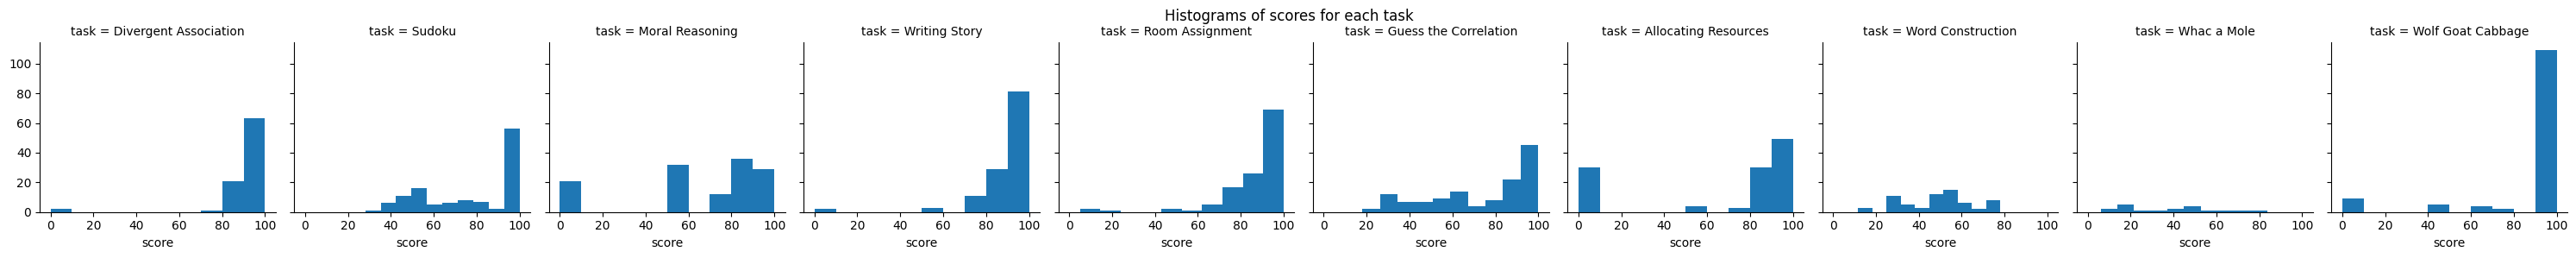

In [54]:
# Get unique tasks
unique_tasks = tasks_and_scores["task"].unique()

# Plot histograms as facets
g = sns.FacetGrid(tasks_and_scores, col="task")
g.map(plt.hist, "score")
g.fig.suptitle("Histograms of scores for each task")
g.fig.subplots_adjust(top=0.85)
plt.show()

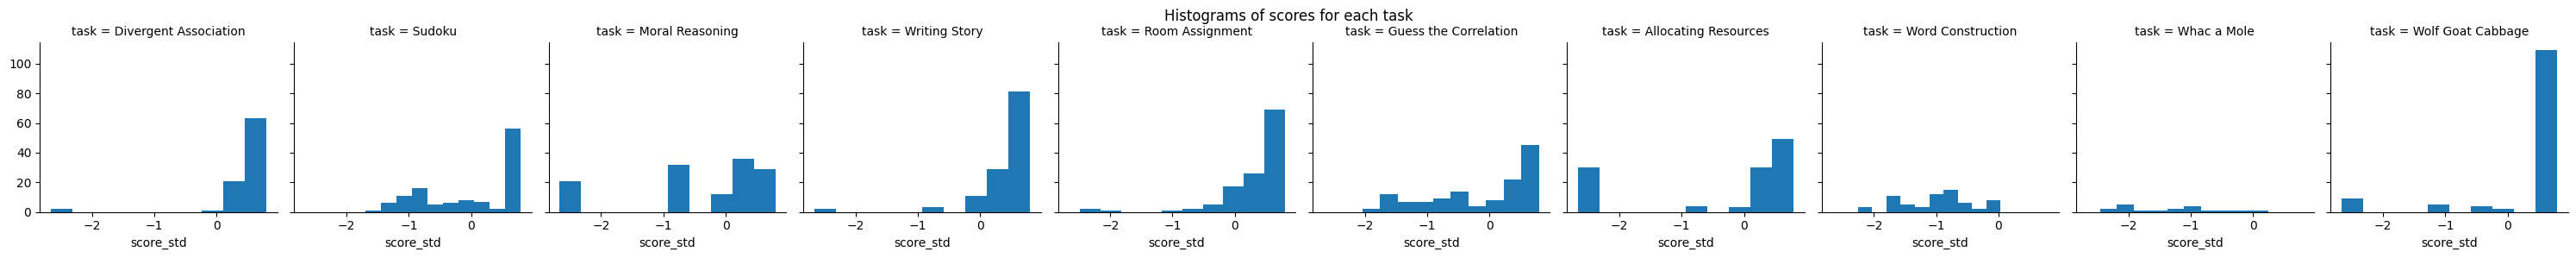

In [55]:
# Standard Normalization
tasks_and_scores["score_std"] = tasks_and_scores["score"].apply(lambda x: (x - tasks_and_scores["score"].mean()) / tasks_and_scores["score"].std())

# Plot histograms as facets
g = sns.FacetGrid(tasks_and_scores, col="task")
g.map(plt.hist, "score_std")
g.fig.suptitle("Histograms of scores for each task")
g.fig.subplots_adjust(top=0.85)
plt.show()

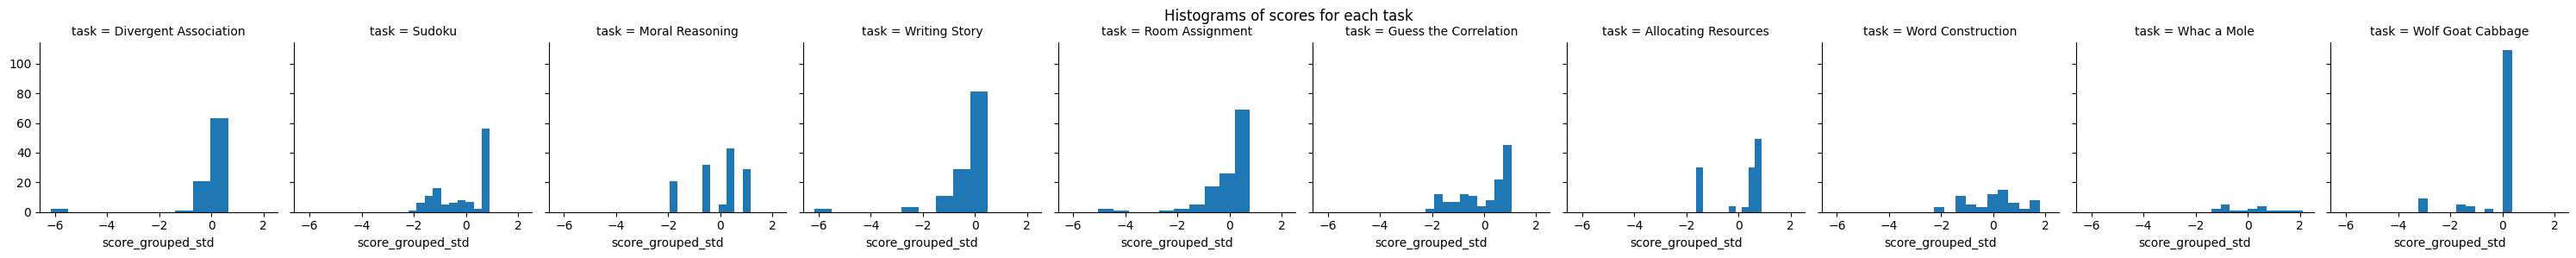

In [62]:
tasks_and_scores["score_grouped_std"] = tasks_and_scores[["task", "score"]].groupby("task").transform(lambda x: (x - x.mean()) / x.std())

# Plot histograms as facets
g = sns.FacetGrid(tasks_and_scores, col="task")
g.map(plt.hist, "score_grouped_std")
g.fig.suptitle("Histograms of scores for each task")
g.fig.subplots_adjust(top=0.85)
plt.show()

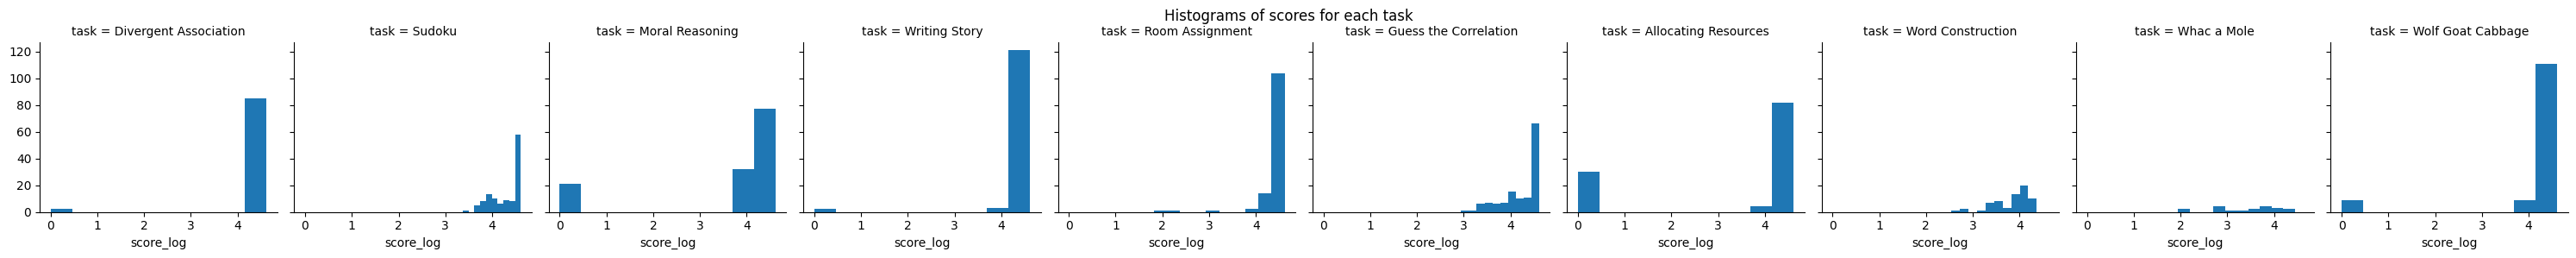

In [63]:
# Log Normalization
tasks_and_scores["score_log"] = tasks_and_scores["score"].apply(lambda x: np.log(x + 1))

# Plot histograms as facets
g = sns.FacetGrid(tasks_and_scores, col="task")
g.map(plt.hist, "score_log")
g.fig.suptitle("Histograms of scores for each task")
g.fig.subplots_adjust(top=0.85)
plt.show()